<a href="https://colab.research.google.com/github/Haamid219/NIDS/blob/main/LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical







In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Step 1: Load and Preprocess the Dataset
def load_and_preprocess_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Clean up column names by stripping any leading/trailing spaces
    df.columns = df.columns.str.strip()

    # List of important features based on feature importance
    important_features = [
        'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
        'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'URG Flag Count',
        'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
        'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
        'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd IAT Mean',
        'Bwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Flow IAT Mean', 'Flow IAT Std',
        'Flow Duration', 'Flow Packets/s', 'Flow Bytes/s', 'Total Length of Fwd Packets',
        'Total Length of Bwd Packets', 'Packet Length Std', 'Packet Length Mean',
        'Min Packet Length', 'Max Packet Length', 'Active Min', 'Active Max',
        'Active Mean', 'Active Std', 'Idle Min', 'Idle Max', 'Idle Mean', 'Idle Std',
        'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
        'Subflow Bwd Packets', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes',
        'Down/Up Ratio'
    ]

    # Ensure the dataset contains the 'Label' column
    if 'Label' not in df.columns:
        raise ValueError("The dataset does not contain a 'Label' column.")

    # Filter the dataset to include only the important features
    df_filtered = df[important_features + ['Label']]  # Ensure 'Label' is correct

    # Handle missing values (Only for numerical features)
    numerical_features = df_filtered.select_dtypes(include=np.number).columns
    df_filtered[numerical_features] = df_filtered[numerical_features].fillna(df_filtered[numerical_features].mean())

    # Encode the labels (converting categorical labels to numeric)
    label_encoder = LabelEncoder()
    df_filtered['Label'] = label_encoder.fit_transform(df_filtered['Label'])  # Encoding labels to integers

    # Separate features (X) and target (y)
    X = df_filtered.drop(columns=['Label'])
    y = df_filtered['Label']

    # Normalize features using MinMaxScaler (scales between 0 and 1)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # One-hot encode the labels (for multi-class classification)
    y_one_hot = to_categorical(y)

    # Split the data into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)

    # Reshape the data to fit into the Conv1D model (samples, features, 1)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test, y


In [15]:
# Step 2: Build the Conv1D + Bidirectional LSTM Model with Dropout Layers
def create_lstm_cnn_bidir_model(input_shape, num_classes):
    model = models.Sequential()

    # Add Conv1D layers to capture local features in the data
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    # Add another Conv1D layer for deeper feature extraction
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    # Add Bidirectional LSTM layer to capture temporal dependencies
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=False)))
    model.add(layers.Dropout(0.4))  # Dropout after LSTM layer

    # Add Dense layers for classification
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid'))  # 'softmax' for multi-class, 'sigmoid' for binary

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])

    return model

In [13]:
# Step 3: Plot Training vs. Testing Accuracy and Loss
def plot_training_vs_testing(history):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


<ipython-input-11-7d5658f792b7>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[numerical_features] = df_filtered[numerical_features].fillna(df_filtered[numerical_features].mean())
<ipython-input-11-7d5658f792b7>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Label'] = label_encoder.fit_transform(df_filtered['Label'])  # Encoding labels to integers
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 46, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,311 (278.56 KB)

 Trainable params: 71,311 (278.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.5132 - loss: 1.4534 - val_accuracy: 0.7767 - val_loss: 0.5265
Epoch 2/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7786 - loss: 0.5474 - val_accuracy: 0.8518 - val_loss: 0.3302
Epoch 3/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8297 - loss: 0.3981 - val_accuracy: 0.8738 - val_loss: 0.2921
Epoch 4/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8502 - loss: 0.3469 - val_accuracy: 0.8726 - val_loss: 0.2732
Epoch 5/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8575 - loss: 0.3244 - val_accuracy: 0.8747 - val_loss: 0.2698
Epoch 6/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8650 - loss: 0.3084 - val_accuracy: 0.8765 - val_loss: 0.2628
Epoch 7/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8683 - loss: 0.2971 - val_accuracy: 0.8841 - val_loss: 0.2555
Epoch 8/10
2297/2297 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.8709 - loss:

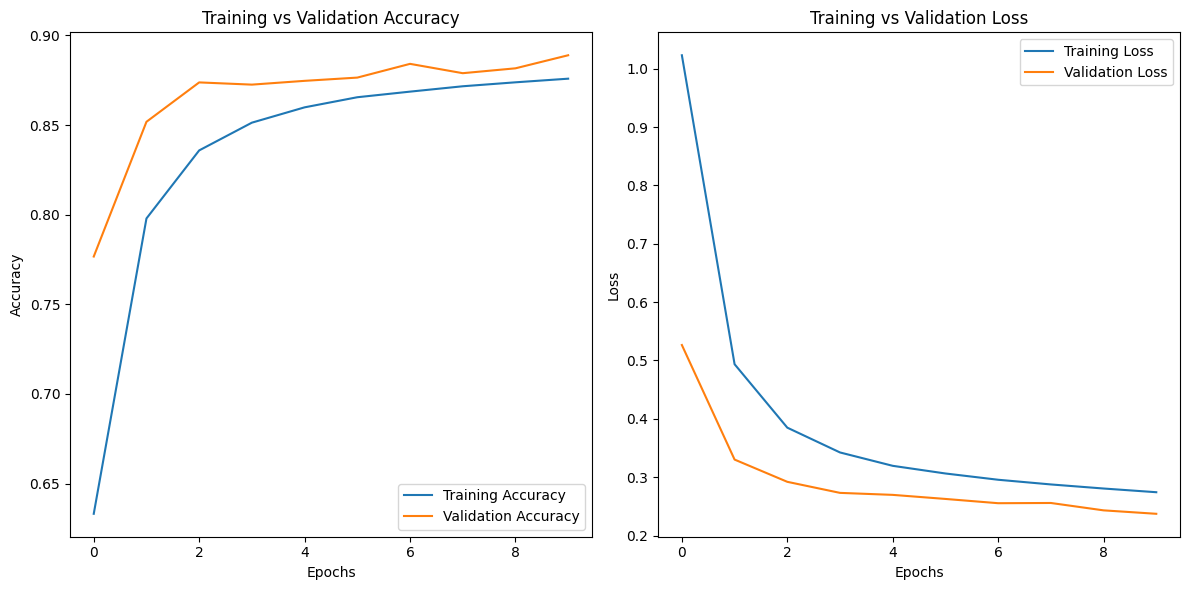

In [16]:
# Step 4: Main Function to Run Everything
def main():
    # Load and preprocess the data
    file_path = '/content/balanced_CIC_IDS2017_with_SMOTE.csv'  # Update with your dataset path
    X_train, X_test, y_train, y_test, y = load_and_preprocess_data(file_path)

    # Create the LSTM + Conv1D + Bidirectional model
    input_shape = (X_train.shape[1], 1)  # Shape should be (features, 1)
    num_classes = y_train.shape[1]  # Number of output classes (for multi-class classification)
    model = create_lstm_cnn_bidir_model(input_shape, num_classes)

    # Print model summary
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_acc}')

    # Plot the training vs test accuracy and loss graphs
    plot_training_vs_testing(history)

if __name__ == "__main__":
    main()
